In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
sen_attr_dict = {
    'adult': 'sex',
    'compas': 'sex',
    'bank': 'age',
    'retiring_adult': 'race',
    'retiring_adult_coverage': 'race'
}

In [3]:
dataset = 'compas'
sen_attr = sen_attr_dict[dataset]
option = 'fair_with_val_loss' # 'fair_only', 'intersect'
constraint = 'eopp'
alpha_arr = np.arange(0.1, 1.1, 0.1)
if dataset == "compas":
    k_arr = np.arange(1, 21, 1)
else:
    k_arr = np.concatenate((np.arange(0.1, 1.1, 0.1), np.arange(1, 3, 1)))
#k_arr = np.arange(0.1, 1.1, 0.1) # np.arange(0.1, 1.1, 0.1) or np.arange(1, 21, 1)
#k_arr = np.arange(1, 21, 1)
seed_arr = [0, 1, 2, 3, 4]

In [4]:
# naive

trng_acc_list = np.array([])
trng_fair_list = np.array([])

val_acc_list = np.array([])
val_fair_list = np.array([])

test_acc_list = np.array([])
test_fair_list = np.array([])

if constraint == "eopp":
    filename = "./log/fair_only/{}_seed_{}_sen_attr_{}_naive_log.txt"
elif constraint == "eo":
    filename = "./log/fair_only/{}_eo_seed_{}_sen_attr_{}_naive_log.txt"

for seed in seed_arr:
    with open(filename.format(dataset, seed, sen_attr), "rb") as fp:
        log = pickle.load(fp)
        max_idx = np.argmax(np.array(log[0]))
        
        trng_acc_list = np.append(trng_acc_list, log[0][max_idx])
        trng_fair_list = np.append(trng_fair_list, log[1][max_idx])
        val_acc_list = np.append(val_acc_list, log[2][max_idx])
        val_fair_list = np.append(val_fair_list, log[3][max_idx])
        test_acc_list = np.append(test_acc_list, log[4][max_idx])
        test_fair_list = np.append(test_fair_list, log[5][max_idx])
        
naive_trng_acc = np.mean(trng_acc_list)
naive_trng_fair = np.mean(trng_fair_list)
naive_val_acc = np.mean(val_acc_list)
naive_val_fair = np.mean(val_fair_list)
naive_test_acc = np.mean(test_acc_list)
naive_test_fair = np.mean(test_fair_list)
        
print(f"Average Trng Acc: {np.mean(trng_acc_list)}, Average Trng Fair: {np.mean(trng_fair_list)}")
print(f"Average Val Acc: {np.mean(val_acc_list)}, Average Val Fair: {np.mean(val_fair_list)}")
print(f"Average Test Acc: {np.mean(test_acc_list)}, Average Test Fair: {np.mean(test_fair_list)}")
    

Average Trng Acc: 0.740481506634959, Average Trng Fair: 0.21431576487086595
Average Val Acc: 0.6800405268490375, Average Val Fair: 0.3032926791422276
Average Test Acc: 0.6813614262560778, Average Test Fair: 0.2324906090406449


In [11]:
# Top k Last Epoch

'''
log[0]: trng acc
log[1]: trng fair
log[2]: val acc
log[3]: val fair
log[4]: test acc
log[5]: test fair
'''

val_acc_log = np.zeros((len(seed_arr), len(k_arr), len(alpha_arr)))
val_fair_log = np.zeros((len(seed_arr), len(k_arr), len(alpha_arr)))
test_acc_log = np.zeros((len(seed_arr), len(k_arr), len(alpha_arr)))
test_fair_log = np.zeros((len(seed_arr), len(k_arr), len(alpha_arr)))


epoch = 50
if constraint == "eopp":
    filename = "./log/{}/{}_eopp_seed_{}_k_{:.1f}_alpha_{:.1f}_sen_attr_{}_acc_fair_log.txt"
elif constraint == "eo":
    filename = "./log/{}/{}_eo_seed_{}_k_{:.1f}_alpha_{:.1f}_sen_attr_{}_acc_fair_log.txt"

for seed_idx, seed in enumerate(seed_arr):
    for k_idx, k in enumerate(k_arr):
        for alpha_idx, alpha in enumerate(alpha_arr):
            with open(filename.format(option, dataset, seed, k, alpha, sen_attr), "rb") as fp:
                log = pickle.load(fp)
                val_acc_log[seed_idx, k_idx, alpha_idx] = log[2][epoch - 1]
                val_fair_log[seed_idx, k_idx, alpha_idx] = log[3][epoch - 1]
                test_acc_log[seed_idx, k_idx, alpha_idx] = log[4][epoch - 1]
                test_fair_log[seed_idx, k_idx, alpha_idx] = log[5][epoch - 1]

# print(f"Average Trng Acc: {np.mean(trng_acc_list)}, Average Trng Fair: {np.mean(trng_fair_list)}")
# print(f"Average Val Acc: {np.mean(val_acc_list)}, Average Val Fair: {np.mean(val_fair_list)}")
# print(f"Average Test Acc: {np.mean(test_acc_list)}, Average Test Fair: {np.mean(test_fair_list)}")

val_acc_log = np.mean(val_acc_log, axis=0)
val_fair_log = np.mean(val_fair_log, axis=0)
test_acc_log = np.mean(test_acc_log, axis=0)
test_fair_log = np.mean(test_fair_log, axis=0)



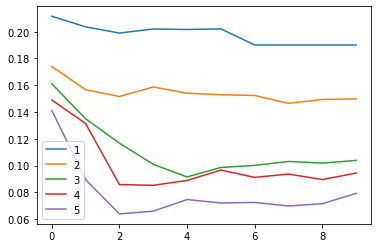

In [37]:
for k_idx, k in enumerate(k_arr):
    if k_idx < 5:
        plt.plot(val_fair_log[k_idx], label=k)
    
plt.legend()


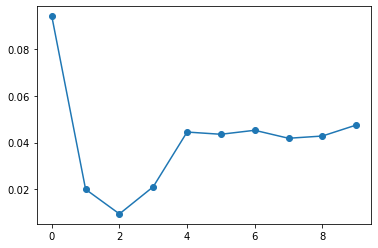

In [21]:
plt.plot(val_fair_log[9], "o-")

[0.09424945 0.01992986 0.00936598 0.02103466 0.04452099 0.04356516
 0.04527822 0.04185209 0.04280793 0.04751885]
